In [1]:
from mpi4py import MPI
import gmsh
import numpy as np
from scipy.spatial import cKDTree
import pyvista as pv
from dolfinx import plot

# --- before the refinement loop (rank 0 only collects) ---
h_list, L2_list, L2_fem_list, rL2_list, rL2s_fem_list, H1s_list, rH1s_list = [], [], [], [], [], [], []
# L2_fem_list_pf, rL2s_fem_list_pf, H1s_list_pf, rH1s_list_pf = [], [], [], []
# L2_fem_list_lmbd, rL2s_fem_list_lmbd, H1s_list_lmbd, rH1s_list_lmbd = [], [], [], []

# plotter = pv.Plotter(shape=(2, 4), window_size=(2000, 1000))
N_ref = 10

Lx, Ly = 1.0, 1.0
# y_start, y_end = 0.0, 1.0
# x_start, x_end = 0.25, 0.75


In [2]:
from dolfinx import mesh, fem
import ufl
import numpy as np
from dolfinx.io import gmsh as gmshio
from mpi4py import MPI

# ---------------------------------------------------------------------
# 1. Mesh and tags (same mesh as reference)
# ---------------------------------------------------------------------
ref = 2
filename = f"regular_mesh_{ref}.msh"
msh, cell_markers, facet_markers = gmshio.read_from_msh(filename, MPI.COMM_WORLD, 0, gdim=2)[0:3]

tdim = msh.topology.dim  # 2
fdim = tdim - 1          # 1

lc = 1.0 / (2**ref)      # mesh size
h = lc

omega = msh

# ---------------------------------------------------------------------
# 2. Function space (standard CG on the bulk only)
# ---------------------------------------------------------------------
order = 1
V = fem.functionspace(omega, ("Lagrange", order))

# ---------------------------------------------------------------------
# 3. Trial / Test / Solution function
# ---------------------------------------------------------------------
phi = ufl.TestFunction(V)
p = fem.Function(V, name="p")
dp = ufl.TrialFunction(V)

# ---------------------------------------------------------------------
# 4. Coordinates and data
# ---------------------------------------------------------------------
x = ufl.SpatialCoordinate(omega)
# f_m = fem.Constant(omega, 0.0)
# f_m = 2*(x[1] - x[1]**2 + x[0] - x[0]**2)
f_m = x[1]
def f_callable(x):
    return x[1]

f = fem.Function(V)
f.interpolate(f_callable)
# create function
k_m = fem.Function(V, name="kappa")

def k_callable(x):
    # x is array with shape (gdim, N). compute scalar per point, return shape (1,N)
    vals = 2*(x[0])
    return vals[np.newaxis, :]

k_m.interpolate(k_callable)

kappa = 1.0
# k_m = fem.Constant(omega, kappa)  # bulk permeability

dx = ufl.Measure("dx", domain=omega)

# compute domain bbox to locate sides
coords = omega.geometry.x
xx = coords[:, 0]
yy = coords[:, 1]
xmin, xmax = xx.min(), xx.max()
ymin, ymax = yy.min(), yy.max()

tol = 1e-10 * max(xmax - xmin, ymax - ymin)

# locate boundary facets for bottom (y = ymin) and top (y = ymax)
bottom_facets = mesh.locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[1], ymin, atol=tol)
)
top_facets = mesh.locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[1], ymax, atol=tol)
)

# create meshtags for those Neumann parts (optional — kept for clarity)
indices = np.concatenate([bottom_facets, top_facets]).astype(np.int32)
values = np.concatenate([
    np.full(bottom_facets.shape, 10, dtype=np.int32),  # bottom tag = 10
    np.full(top_facets.shape,    20, dtype=np.int32),  # top tag    = 20
])
neumann_tags = mesh.meshtags(omega, fdim, indices, values)

# boundary measure (we'll use ds over the whole boundary with conditional g_N)
dsN = ufl.Measure("ds", domain=omega)  # we integrate g_N over the boundary

# Neumann data as conditional on the y coordinate (same as reference)
# g_N = ufl.conditional(
#     ufl.lt(abs(x[1] - ymax), tol),
#     -1.0,                                # top
#     ufl.conditional(
#         ufl.lt(abs(x[1] - ymin), tol),
#         2.0,                             # bottom
#         0.0                              # elsewhere
#     ),
# )

# ---------------------------------------------------------------------
# 5. Weak form (standard Darcy / Poisson form)
# ---------------------------------------------------------------------
a = ufl.inner(k_m * ufl.grad(dp), ufl.grad(phi)) * dx
L = f_m * phi * dx
# L -= g_N * phi * dsN

# Form for assembling (bilinear/trilinear functions expect TrialFunction in a)
A_form = ufl.inner(k_m * ufl.grad(dp), ufl.grad(phi)) * dx
b_form = L

# ---------------------------------------------------------------------
# 6. Dirichlet BCs (left/right like reference)
# ---------------------------------------------------------------------
# locate dofs on each side
left_dofs   = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], xmin, atol=tol))
right_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], xmax, atol=tol))
top_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[1], ymax, atol=tol))
bottom_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[1], ymin, atol=tol))

all_dofs = np.unique(np.concatenate([left_dofs, right_dofs]))
dof_coords = V.tabulate_dof_coordinates()

p_bc_fun = fem.Function(V)
p_bc_fun.x.array[left_dofs] = 0.0
p_bc_fun.x.array[right_dofs] = dof_coords[right_dofs, 1] / 2.0
# p_bc_fun.x.array[top_dofs] = 0.0
# p_bc_fun.x.array[bottom_dofs] = 0.0

bc = fem.dirichletbc(p_bc_fun, all_dofs)
bcs = [bc]

# ---------------------------------------------------------------------
# 7. Solve linear problem using dolfinx.fem.petsc.LinearProblem
# ---------------------------------------------------------------------
from dolfinx.fem import petsc

linear_problem = petsc.LinearProblem(
    a=A_form,
    L=b_form,
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "ksp_error_if_not_converged": True,
    },
    petsc_options_prefix="pmix_"
)

p_sol = linear_problem.solve()
p_sol.name = "pressure"

# optionally copy into p Function if you prefer
p.x.array[:] = p_sol.x.array[:]

# ---------------------------------------------------------------------
# 8. Diagnostics
# ---------------------------------------------------------------------
print("DOFs in V:", V.dofmap.index_map.size_global)


Info    : Reading 'regular_mesh_2.msh'...
Info    : 153 entities
Info    : 25 nodes
Info    : 153 elements
Info    : Done reading 'regular_mesh_2.msh'
DOFs in V: 25


In [3]:
from dolfinx import geometry
def eval_scalar_at_point(u, point):
    """
    Evaluate a scalar dolfinx.fem.Function `u` at a single physical point.

    Parameters
    ----------
    u : dolfinx.fem.Function or float/int
    point : sequence of length mesh.dim

    Returns
    -------
    float
    """
    # allow plain scalars
    if isinstance(u, (float, int, np.floating, np.integer, np.float64)):
        return float(u)
    point = np.asarray(point)
    if point.ndim == 1:
        point = point.reshape(-1, 1)
    V = u.function_space
    mesh = V.mesh
    tdim = mesh.topology.dim
    gdim = mesh.geometry.dim

    # X = np.asarray(point, dtype=np.float64).reshape(1, -1)  # shape (1, dim)
    _gdim, N = point.shape
    if _gdim != gdim:
        raise ValueError(f"Point array has gdim={_gdim}, expected {gdim}")

    # dolfinx expects 3D coordinates; pad in 2D
    if gdim == 2:
        X = np.column_stack([point.T, np.zeros(N, dtype=np.float64)])  # (N, 3)
    elif gdim == 3:
        X = point.T.copy()                                             # (N, 3)
    else:
        raise ValueError(f"Unsupported geometric dimension gdim={gdim}")

    # 1) bounding-box tree + collision test
    bbt = geometry.bb_tree(mesh, tdim)
    cands = geometry.compute_collisions_points(bbt, X)
    hits = geometry.compute_colliding_cells(mesh, cands, X)

    # pick first hit if any
    cell = -1
    links = hits.links(0)
    if len(links) > 0:
        cell = int(links[0])

    # 2) fallback: nearest entity (robust for boundary points / tiny roundoff)
    if cell == -1:
        mid_tree = geometry.create_midpoint_tree(
            mesh, tdim,
            np.arange(mesh.topology.index_map(tdim).size_local, dtype=np.int32)
        )
        nearest = geometry.compute_closest_entity(bbt, mid_tree, mesh, X)
        cell = int(nearest[0])

    # 3) Evaluate using dolfinx Function.eval
    # Try the common signature that returns an array: val = u.eval(X, cells)
    try:
        vals = np.asarray(u.eval(X, np.array([cell], dtype=np.int32))).ravel()
        return float(vals[0])
    except Exception:
        # Alternative signature: u.eval(values_buffer, X, cell)
        # Prepare buffer of correct size (value_size per point)
        vsize = getattr(u, "value_size", 1)
        buf = np.zeros((vsize, 1), dtype=np.float64) if vsize > 1 else np.zeros(1, dtype=np.float64)
        try:
            # note: some dolfinx versions expect (buf, X, cell)
            u.eval(buf, X, cell)
            return float(np.asarray(buf).ravel()[0])
        except Exception as e:
            raise RuntimeError(f"Failed to evaluate Function at point {point}: {e}")

In [4]:
# Access mesh geometry
tdim = omega.topology.dim
# assert tdim == 2, "This implementation is for triangular 2D meshes"
# assert V.ufl_element().degree == 1, "Only P1 supported in this implementation"

# Gather coordinates and connectivity
omega_geometry = omega.geometry.x[:,0:2]  # global array of vertex coords
# Build cell->vertex mapping (fast access)
# Using dolfinx.Cell to get connectivity is more robust, but below uses mesh.topology
cells = omega.topology.connectivity(0, tdim)  # vertices -> cells
# Instead get cell->vertex mapping via mesh.topology.index_map?
# Simpler: use mesh.geometry.x with mesh.topology.connectivity(tdim, 0)
ctv = omega.topology.connectivity(tdim, 0)
if ctv is None:
    omega.topology.create_connectivity(tdim, 0)
    ctv = omega.topology.connectivity(tdim, 0)
# ctv.array() gives flattened vertex indices -> need per-cell view
# There's a helper to get cell entity indices
num_cells = omega.topology.index_map(tdim).size_local  # per-rank local count
# We'll iterate over local cells only
local_cells = np.arange(num_cells, dtype=np.int32)

# For evaluating u_h and kappa, we can use u_h.x.array if needed.
# But easier: create a point evaluation lambda to get value at a point
from dolfinx.fem import Function
u_func = p_sol

# Precompute reference basis grads in physical coords per cell:
# For P1, grad phi_j is constant on cell; we can compute using inverse Jacobian
# For each local cell:
local_fluxes = {}
V_dofmap = V.dofmap.index_map.local_range  # not directly used; we'll query dofs per cell

# Get dof indices per cell
# Using dolfinx.fem.locate_dofs_topological is one option, but below we get cell_dofs
dofmap = V.dofmap
# iterate over local cells using mesh.topology.connectivity(tdim, 0)
# cell_to_vertices = ctv.links().reshape((-1, 3))  # might be shape (num_cells, 3)
# cell_to_vertices = np.array([ctv.links(c) for c in range(ctv.num_nodes)])

# But to avoid uncertain reshape semantics, use mesh.topology.connectivity(tdim, 0).entities
# Simpler robust approach: use dolfinx.mesh.cells() to get local cells vertex indices
try:
    from dolfinx.mesh import cells as dolfinx_cells
    local_cell_vertices = dolfinx_cells(mesh)
except Exception:
    # fallback: create by slicing connectivity
    # arr = ctv.array
    # local_cell_vertices = arr.reshape((-1, 3))
    local_cell_vertices = np.array([ctv.links(c) for c in range(ctv.num_nodes)])

In [5]:
ref_grads = np.array([[-1.0, -1.0],[1.0, 0.0],[0.0, 1.0]])
elem_grad_u = {}
elem_area = {}
elem_kappa_cent = {}
from tqdm import tqdm

  0%|          | 0/512 [00:00<?, ?it/s]

100%|██████████| 512/512 [02:02<00:00,  4.19it/s]


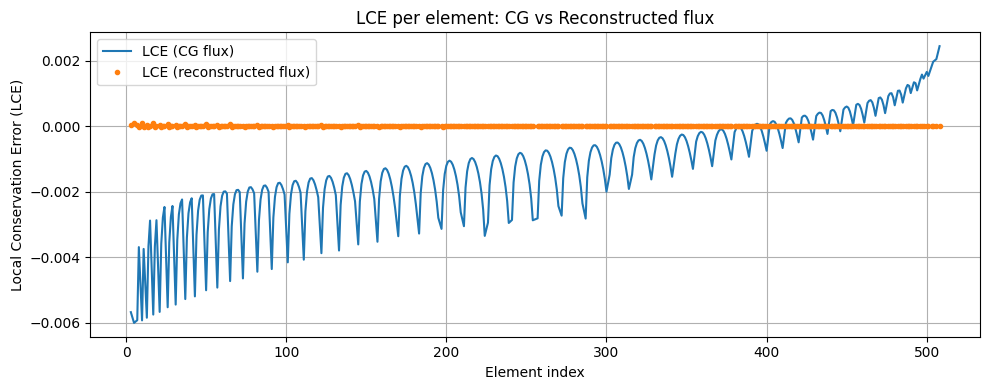

CG LCE stats: {'min': -0.006003117505676121, 'max': 0.002438592789572943, 'L1_mean_abs': 0.001492693584011395, 'L2_rms': 0.0019014356027301429}
Reconstructed LCE stats: {'min': -3.769969731230423e-05, 'max': 9.445284725452313e-05, 'L1_mean_abs': 1.0028721669813123e-05, 'L2_rms': 1.3787583097884342e-05}


In [ ]:
import basix
coef_glob = {i: [] for i in range(len(omega.geometry.x))}
dict_sig ={}
dict_mu = {}
bb = geometry.bb_tree(omega, omega.topology.dim)

import matplotlib.pyplot as plt
from dolfinx import mesh as dmesh
# geometry + local cell vertices
# geometry = mesh.geometry.x.copy()
# local_cell_vertices = dolfinx_cells(mesh)
num_local_cells = local_cell_vertices.shape[0]

# map vertex -> adjacent local cells
vertex_to_cells = {}
for local_cell_idx, verts in enumerate(local_cell_vertices):
    for v in verts:
        vertex_to_cells.setdefault(int(v), []).append(int(local_cell_idx))

# compute element-wise gradients (P1)
dofmap = V.dofmap

# Ensure we have cell–facet connectivity
omega.topology.create_connectivity(tdim, fdim)
c2f = omega.topology.connectivity(tdim, fdim)

# compute LCEs per vertex (control-volume)
vertex_ids = sorted(list(vertex_to_cells.keys()))
LCE_CG = []
LCE_rec = []
indices = []

LCE_CG_int = []
LCE_rec_int = []
indices_int = []

num_dofs = V.dofmap.index_map.size_global
coef_glob = {i: [] for i in range(num_dofs)}
# Iterate local cells
for vid in tqdm(vertex_ids):
    flux_sum_CG = 0.0
    flux_sum_rec = 0.0
    source_sum = 0.0
    adjacent_cells = vertex_to_cells[vid]
    vertex_coord = omega_geometry[vid]

    for local_cell_idx in adjacent_cells:
        verts = local_cell_vertices[local_cell_idx]
        local_idx = int(list(verts).index(vid))
        coords = omega_geometry[verts]
        centroid = np.mean(coords, axis=0).reshape(1,-1)
    # cell_verts are global vertex indices
    # coords = omega_geometry[cell_verts]  # shape (3,2)
    # centroid = np.mean(coords, axis=0).reshape(1,-1)

        loc_cells = np.array([[0, 1, 2]], dtype=np.int64)

        gdim = coords.shape[1]
        coord_el = basix.ufl.element("Lagrange", "triangle", 1, shape=(gdim,))

        local_mesh = mesh.create_mesh(
            MPI.COMM_SELF,
            loc_cells,
            coord_el,   # <-- this is the required "e" argument
            coords
        )
        cell_dofs = V.dofmap.cell_dofs(local_cell_idx)

        Sigma_loc = fem.functionspace(local_mesh, ("RT", 2)) 
        mu_loc = fem.functionspace(local_mesh, ("CG", 1)) #mu_loc -> mu, nu

        RT = basix.ufl.element("RT", local_mesh.basix_cell(), 2)
        CG = basix.ufl.element("Lagrange", local_mesh.basix_cell(), 1)
        W_el = basix.ufl.mixed_element([RT, CG])

        W = fem.functionspace(local_mesh, W_el)

        x_loc = ufl.SpatialCoordinate(local_mesh)
        f_loc = x_loc[1]

        # ================= trial and test functions =================
        tau, nu = ufl.TestFunctions(W)
        sig, mu = ufl.TrialFunctions(W)

    # Measures and normal
    dx = ufl.Measure("dx", domain=local_mesh)

    # local copy of p on local_mesh in CG1
    p_loc = fem.Function(mu_loc)

    Xdofs = mu_loc.tabulate_dof_coordinates()          # (ndofs, gdim)
    pts = np.zeros((Xdofs.shape[0], 3), dtype=np.float64)
    pts[:, :Xdofs.shape[1]] = Xdofs

    from dolfinx import geometry

    # centroid -> shape (1, 3)
    c = np.zeros((1, 3), dtype=np.float64)
    c[0, :gdim] = np.mean(coords, axis=0)

    cands = geometry.compute_collisions_points(bb, c)
    colliding = geometry.compute_colliding_cells(omega, cands, c)

    links = colliding.links(0)
    assert len(links) > 0, "Centroid not found in any cell (unexpected)."
    cell_id = int(links[0])

    cells = np.full((pts.shape[0],), cell_id, dtype=np.int32)

    vals = p_sol.eval(pts, cells)  # <- returns numpy array
    # vals is typically shape (num_points, 1) for scalar functions
    p_loc.x.array[:] = vals.reshape(-1)

    # p_loc.x.array[:] = vals

    # ================= bulk mixed weak form on Ω =================
    a_m0 = (
        ufl.inner(sig, tau)                    # here we effectively use k^{-1}=I
        - mu * ufl.div(tau)             # - p div(k v)
        + nu * ufl.div(sig)                   # (div u) q
    ) * dx

    # Coupling with λ via averaged bulk pressure test on Γ
    # a_m1 = - lmbd * avg_qm * ds

    a_m = a_m0

    # RHS: source + weak Dirichlet p on left/right (via g_D)
    L_m = (ufl.inner(ufl.grad(p_loc), tau) + f_loc * nu) * dx

    # ---------------------------------------------------------------------
    # 6. Dirichlet BCs (left/right like reference)
    # ---------------------------------------------------------------------
    mu_loc = W.sub(1)
    Q, collapse_map = mu_loc.collapse()

    # locate dofs consistently between subspace and collapsed space
    left_dofs_mu, left_dofs_Q = fem.locate_dofs_geometrical(
        (mu_loc, Q), lambda x: np.isclose(x[0], xmin, atol=tol)
    )
    right_dofs_mu, right_dofs_Q = fem.locate_dofs_geometrical(
        (mu_loc, Q), lambda x: np.isclose(x[0], xmax, atol=tol)
    )
    dofs_mu_Q = fem.locate_dofs_geometrical((mu_loc, Q),
                                                lambda x: np.isclose(x[0], xmin, atol=tol)
                                                        | np.isclose(x[0], xmax, atol=tol))

    # Define BC values on the collapsed space Q
    p_bc_fun = fem.Function(Q)
    dof_coords_Q = Q.tabulate_dof_coordinates()

    p_bc_fun.x.array[left_dofs_Q] = 0.0
    p_bc_fun.x.array[right_dofs_Q] = dof_coords_Q[right_dofs_Q, 1] / 2.0

    # if (len(left_dofs_Q) == 0) and (len(right_dofs_Q) == 0):
    local_i_select = []
    gd_select = []
    for local_i, gd in enumerate(cell_dofs):
        if len(coef_glob[gd]) != 0:
            local_i_select.append(local_i)
            gd_select.append(gd)
    # p_bc_fun.x.array[local_i_select[0]] = float(coef_glob[gd_select[0]][-1])

        # all_dofs_mu = np.unique(np.concatenate([dofs_mu_Q[0], dofs_mu_Q[1], np.array([collapse_map[local_i_select[0]]])]))
    if len(local_i_select) != 0:
        p_bc_fun.x.array[local_i_select[0]] = float(coef_glob[gd_select[0]][-1])
        # all_dofs_mu = [
        #                 np.concatenate([dofs_mu_Q[0], np.array([collapse_map[ii] for ii in local_i_select], dtype=np.int32)]),
        #                 np.concatenate([dofs_mu_Q[1], np.array(local_i_select, dtype=np.int32)])
        #             ]
        all_dofs_mu = [
                        np.concatenate([dofs_mu_Q[0], np.array([collapse_map[local_i_select[0]]], dtype=np.int32)]),
                        np.concatenate([dofs_mu_Q[1], np.array([local_i_select[0]], dtype=np.int32)])
                    ]
    else:

        # all_dofs_mu = dofs_mu_Q
    # else:
        # all_dofs_mu = np.unique(np.concatenate([left_dofs_mu, right_dofs_mu]))
        all_dofs_mu = dofs_mu_Q
    # bc = fem.dirichletbc(p_bc_fun, all_dofs_mu)
    bc = fem.dirichletbc(p_bc_fun, all_dofs_mu, mu_loc)
    bcs = [bc]


    # ---------------------------------------------------------------------
    # 7. Solve linear problem using dolfinx.fem.petsc.LinearProblem
    # ---------------------------------------------------------------------
    from dolfinx.fem import petsc

    linear_problem = petsc.LinearProblem(
        a=a_m,
        L=L_m,
        bcs=bcs,
        petsc_options={
            "ksp_type": "preonly",
            "pc_type": "lu",
            "pc_factor_mat_solver_type": "mumps",
            "ksp_error_if_not_converged": True,
        },
        petsc_options_prefix="pmix_"
    )

    # sig, mu = linear_problem.solve()
    wh = linear_problem.solve()
    W_sol = wh.function_space
    sig = wh.sub(0).collapse()
    mu  = wh.sub(1).collapse()
    # sig.name = "sig"
    # mu.name = "mu"
    # dict_sig[local_cell_idx] = sig
    # dict_mu[local_cell_idx] = mu
    
    for local_i, gd in enumerate(cell_dofs):
        coef_glob[gd].append(mu.x.array[local_i])

    flux_sum_CG = 0.0
    flux_sum_rec = 0.0
    source_sum = 0.0
    coords = omega_geometry[cell_verts]
    centroid = np.mean(coords, axis=0).reshape(1,-1)

    loc_cells = np.array([[0, 1, 2]], dtype=np.int64)

    gdim = coords.shape[1]
    # coord_el = basix.ufl.element("Lagrange", "triangle", 1, shape=(gdim,))

    # local_mesh = mesh.create_mesh(
    #     MPI.COMM_SELF,
    #     loc_cells,
    #     coord_el,   # <-- this is the required "e" argument
    #     coords
    # )

    V_loc = fem.functionspace(local_mesh, ("CG", 1))
    p_K = fem.Function(V_loc)

    # DOFs on this cell in the global space
    global_dofs = V.dofmap.cell_dofs(local_cell_idx)

    # DOFs on the (only) cell in the local space
    local_dofs = V_loc.dofmap.cell_dofs(0)

    p_K.x.array[local_dofs] = p_sol.x.array[global_dofs]
    p_K.x.scatter_forward()

    n_K = ufl.FacetNormal(local_mesh)

    k_m_loc = fem.Function(V_loc)
    k_m_loc.x.array[local_dofs] = k_m.x.array[global_dofs]
    k_m_loc.x.scatter_forward()

    # k_m can be a scalar or UFL expression; if it's a Function on the global mesh
    # and varies per cell, you'd restrict it similarly to p_K
    q_CG = -k_m_loc * ufl.grad(p_K)

    flux_sum_CG = fem.assemble_scalar(
        fem.form(ufl.dot(q_CG, n_K) * ufl.ds(domain=local_mesh))
    )

    q_rec = sig
    Q_loc = fem.functionspace(local_mesh, ("RT", 2))
    q_rec_K = fem.Function(Q_loc)

    q_rec_K.x.array[:] = q_rec.x.array[:]
    q_rec_K.x.scatter_forward()
    
    flux_sum_rec = fem.assemble_scalar(
        fem.form(ufl.dot(q_rec_K, n_K) * ufl.ds(domain=local_mesh))
    )

    if f is not None:
        f_m_loc = fem.Function(V_loc)
        f_m_loc.x.array[local_dofs] = f.x.array[global_dofs]
        f_m_loc.x.scatter_forward()
        source_sum = fem.assemble_scalar(fem.form(f_m_loc * ufl.dx(domain=local_mesh)))
    LCE_CG.append(flux_sum_CG - source_sum)
    LCE_rec.append(flux_sum_rec - source_sum)
    indices.append(local_cell_idx)

    if (len(left_dofs_Q) == 0) and (len(right_dofs_Q) == 0):
        LCE_CG_int.append(flux_sum_CG - source_sum)
        LCE_rec_int.append(flux_sum_rec - source_sum)
        indices_int.append(local_cell_idx)
    
indices_plot = np.array(indices_int, dtype=int)
LCE_CG_plot = np.array(LCE_CG_int, dtype=float)
LCE_rec_plot = np.array(LCE_rec_int, dtype=float)

# plot
plt.figure(figsize=(10,4))
plt.plot(indices_plot, LCE_CG_plot, label="LCE (CG flux)")
plt.plot(indices_plot, LCE_rec_plot, ".", label="LCE (reconstructed flux)")
plt.xlabel("Element index")
plt.ylabel("Local Conservation Error (LCE)")
plt.title("LCE per element: CG vs Reconstructed flux")
plt.legend()
plt.grid(True)
plt.tight_layout()
# out_path = "/mnt/data/lce_plot.png"
# plt.savefig(out_path)
plt.show()

# print stats & produce dataframe
def stats(arr):
    return {"min": float(arr.min()), "max": float(arr.max()), "L1_mean_abs": float(np.mean(np.abs(arr))), "L2_rms": float(np.sqrt(np.mean(arr**2)))}
print("CG LCE stats:", stats(LCE_CG_plot))
print("Reconstructed LCE stats:", stats(LCE_rec_plot))


In [43]:
local_cell_vertices[15]

array([12, 14,  9], dtype=int32)

In [44]:
coef_glob[12], coef_glob[15], coef_glob[9]

([np.float64(7.692726126627252e-05),
  np.float64(7.692726126627252e-05),
  np.float64(7.692726126627252e-05),
  np.float64(7.692726126627252e-05),
  np.float64(7.692726126627252e-05),
  np.float64(7.692726126627252e-05)],
 [np.float64(6.932039954982722e-05),
  np.float64(6.932039954982722e-05),
  np.float64(6.932039954982722e-05),
  np.float64(6.932039954982722e-05),
  np.float64(6.932039954982722e-05),
  np.float64(6.932039954982722e-05)],
 [np.float64(8.213777828803628e-05),
  np.float64(8.213777828803628e-05),
  np.float64(8.213777828803628e-05)])

In [45]:
dofs_mu_Q

[array([ 9, 10], dtype=int32), array([1, 2], dtype=int32)]